# Install Libraries

In [ ]:
!pip3 install parsivar
!pip install nltk==3.2.2
!pip install clean_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.7 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.2
    Uninstalling nltk-3.2.2:
      Successfully uninstalled nltk-3.2.2
  Using cached nltk-3.2.2-py3-none-any.whl
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nltk-3.8.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
parsivar 0.2.3.1 requires nltk>=3.6.6, but you have nltk 3.2.2 which is incompatible.


In [ ]:
from parsivar import Tokenizer , Normalizer
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from cleantext import clean
from torch import cuda
from parsivar import Tokenizer
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import transformers
from transformers import DistilBertTokenizer, DistilBertModel, BertConfig, BertTokenizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import warnings
import logging
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter('ignore')

# PreProcessing

In [ ]:
# Initialize the Parsivar Normalizer
normalizer = Normalizer(statistical_space_correction=True)
tokenizer = Tokenizer()

def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>') # regular expression for finding tags
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

def cleaning(text):
    text = text.strip() # first and last white spaces will be removed.

    # regular cleaning
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
    )

    # cleaning htmls
    text = cleanhtml(text)

    text = normalizer.normalize(text)

    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
    text = wierd_pattern.sub(r'', text)
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text) # covert multiple white spaces to single one
    return text

In [ ]:
# train data
df = pd.read_csv('/content/train.tsv',sep='\t' , names=['text', 'labels'])
df.head()

,text,labels
0,خیلی کوچیک هستن و سایزشون بدرد نمیخوره میخوام ...,SAD
1,از صدای پرنده دم دمای صبح متنفرم متنفرم متنفرم,HATE
2,"""کیفیتش خیلی خوبه با شک خریدم ولی واقعا راضیم...",SAD
3,چون همش با دوربین ثبت شده ، ایا میشه اعتراض زد...,OTHER
4,اين وضع ب طرز خنده داري گريه داره ...,SAD


In [ ]:
df['text'] = df['text'].apply(cleaning)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,text,labels
0,چه‌فضولم‌هستن تعداد مریضا‌بشما‌چه اخه,ANGRY
1,اسماعیل _ بخشی رو می‌بینم ، شرم می‌کنم از اسم...,SAD
2,ساعت 2 : 30 شبه و همسایه داره زن و بچه‌ش‌رو‌می...,ANGRY
3,توکلی در میان مالباختگان کاسپین : اعتراض شما ب...,OTHER
4,بدم میاد‌پسرایی که مو بلند‌میکنن‌کش‌میبدن ... ...,HATE


In [ ]:
# test data
df_test = pd.read_csv('/content/test.tsv',sep='\t' , names=['text', 'labels'])
df_test.head()

,text,labels
0,اين شايد اولين عزاى عمومى واقعى است كه ياد دار...,SAD
1,دیشب بعد از ارسال تویت مربوط به آثار باستانی ت...,HAPPY
2,کدوم شعبه پول نداده، بگو الان برات آمار دقیق ...,OTHER
3,امروز وسط یه بحث با بابا مامانم گفتم آدم باید ...,HAPPY
4,امشب گفت نامزدی دوستش که ادم روشنفکری است بهم ...,SAD


In [ ]:
df_test['text'] = df_test['text'].apply(cleaning)
df_test = df.sample(frac=1).reset_index(drop=True)
df_test.head()

,text,labels
0,زوداشکم‌درمیاد‌مخصوصاوسط‌دعوااگه یکی سرم‌دادبز...,HATE
1,وقتی کیف به دست رسیدم از انتخابم پشیمان شدم خی...,SAD
2,خواستی بیا بگو ولی بلاک نکن از بلاک بدم میاد,HATE
3,""" من ده روز هست اوردم خیلی خوب بود هم برای مو...",SAD
4,چرررا,SURPRISE


# Label One-Hot Encoding

In [ ]:
def one_hot_encoder(df):
  for index, row in df.iterrows():
    if row["labels"] =="ANGRY":
        row["labels"]=[0, 0, 0, 0, 0, 0, 1]
    elif row["labels"] =="FEAR":
        row["labels"]=[0, 0, 0, 0, 0, 1, 0]
    elif row["labels"] =="HAPPY":
        row["labels"]=[0, 0, 0, 0, 1, 0, 0]
    elif row["labels"] =="HATE":
        row["labels"]=[0, 0, 0, 1, 0, 0, 0]
    elif row["labels"] =="SAD":
        row["labels"]=[0, 0, 1, 0, 0, 0, 0]
    elif row["labels"] =="SURPRISE":
        row["labels"]=[0, 1, 0, 0, 0, 0, 0]
    elif row["labels"] =="OTHER":
        row["labels"]=[1, 0, 0, 0, 0, 0, 0]

In [ ]:
categories = ["ANGRY", "FEAR", "HAPPY", "HATE", "SAD", "SURPRISE","OTHER"]

# Convert emotion labels to numerical format (one-hot encoding)
one_hot_encoder(df) # train
one_hot_encoder(df_test) # test

In [ ]:
df.head()

,text,labels
0,چه‌فضولم‌هستن تعداد مریضا‌بشما‌چه اخه,"[0, 0, 0, 0, 0, 0, 1]"
1,اسماعیل _ بخشی رو می‌بینم ، شرم می‌کنم از اسم...,"[0, 0, 1, 0, 0, 0, 0]"
2,ساعت 2 : 30 شبه و همسایه داره زن و بچه‌ش‌رو‌می...,"[0, 0, 0, 0, 0, 0, 1]"
3,توکلی در میان مالباختگان کاسپین : اعتراض شما ب...,"[1, 0, 0, 0, 0, 0, 0]"
4,بدم میاد‌پسرایی که مو بلند‌میکنن‌کش‌میبدن ... ...,"[0, 0, 0, 1, 0, 0, 0]"


In [ ]:
df_test.head()

,text,labels
0,زوداشکم‌درمیاد‌مخصوصاوسط‌دعوااگه یکی سرم‌دادبز...,"[0, 0, 0, 1, 0, 0, 0]"
1,وقتی کیف به دست رسیدم از انتخابم پشیمان شدم خی...,"[0, 0, 1, 0, 0, 0, 0]"
2,خواستی بیا بگو ولی بلاک نکن از بلاک بدم میاد,"[0, 0, 0, 1, 0, 0, 0]"
3,""" من ده روز هست اوردم خیلی خوب بود هم برای مو...","[0, 0, 1, 0, 0, 0, 0]"
4,چرررا,"[0, 1, 0, 0, 0, 0, 0]"


# Initialization

In [ ]:
device = 'cuda' if cuda.is_available() else 'cpu' # gpu for parallel computation
print(f"Device is {device}")

Device is cuda


In [ ]:
MAX_LEN=512
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 1e-03
MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)

# Data

In [ ]:
from transformers import BertModel
# DistilBertModel: https://huggingface.co/docs/transformers/en/model_doc/distilbert

class ParsBertModel(torch.nn.Module):
    def __init__(self):
        super(ParsBertModel, self).__init__()
        self.l1 = DistilBertModel.from_pretrained(MODEL_NAME_OR_PATH)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, 7)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0] # extract hidden states of the output of pre-trained model
        pooler = hidden_state[:, 0] # selecting the hidden states corresponding to the first token in each sequence
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

model = ParsBertModel()
model.to(device)

In [ ]:
print("TRAIN Dataset: {}".format(df.shape))
print("TEST Dataset: {}".format(df_test.shape))

training_set = MultiLabelDataset(df, tokenizer, MAX_LEN)
test_set = MultiLabelDataset(df_test, tokenizer, MAX_LEN)

TRAIN Dataset: (6125, 2)
TEST Dataset: (6125, 2)


**Data Loader**

In [ ]:
train_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0 # done in the main process(because of small dataset)
                }

test_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0 # done in the main process
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(test_set, **test_params)

# Model

In [ ]:
from transformers import BertModel
# DistilBertModel: https://huggingface.co/docs/transformers/en/model_doc/distilbert

class ParsBertModel(torch.nn.Module):
    def __init__(self):
        super(ParsBertModel, self).__init__()
        self.l1 = DistilBertModel.from_pretrained(MODEL_NAME_OR_PATH)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, 7)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0] # extract hidden states of the output of pre-trained model
        pooler = hidden_state[:, 0] # selecting the hidden states corresponding to the first token in each sequence
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

model = ParsBertModel()
model.to(device)

You are using a model of type bert to instantiate a model of type distilbert. This is not supported for all configurations of models and can yield errors.
Some weights of DistilBertModel were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['transformer.layer.2.sa_layer_norm.bias', 'transformer.layer.6.ffn.lin1.weight', 'transformer.layer.6.output_layer_norm.bias', 'transformer.layer.2.attention.out_lin.weight', 'transformer.layer.3.attention.out_lin.bias', 'transformer.layer.0.attention.v_lin.weight', 'transformer.layer.5.attention.out_lin.bias', 'transformer.layer.5.sa_layer_norm.weight', 'transformer.layer.1.attention.q_lin.bias', 'transformer.layer.7.attention.v_lin.bias', 'transformer.layer.0.attention.k_lin.weight', 'transformer.layer.9.sa_layer_norm.weight', 'transformer.layer.11.attention.k_lin.weight', 'transformer.layer.4.ffn.lin2.bias', 'transformer.layer.10.ffn.lin2.bias', 'transformer.layer.9.ffn.lin1.weight', 'tran

ParsBertModel(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-11): 12 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(i

In [ ]:
def loss_fn(outputs, targets): # binary class entropy and sigmoid
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
def train(epoch):
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        last_loss = loss.item()

        loss.backward()
        optimizer.step() # update model parameters
    print(f'Epoch: {epoch}, Loss:  {last_loss}')

In [ ]:
for epoch in range(EPOCHS):
    train(epoch)

307it [07:03,  1.38s/it]


Epoch: 0, Loss:  0.7145049571990967


307it [07:02,  1.38s/it]


Epoch: 1, Loss:  0.7405228018760681


307it [07:03,  1.38s/it]


Epoch: 2, Loss:  0.7072389125823975


307it [07:02,  1.38s/it]


Epoch: 3, Loss:  0.7084183096885681


307it [07:01,  1.37s/it]

Epoch: 4, Loss:  0.7277242541313171


**Evaluate**

In [ ]:
def predict(testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist()) # detach:to prevent gradients from being calculated with respect to the targets
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist()) # appending the model predictions (after sigmoid activation)
    return fin_outputs, fin_targets

In [ ]:
outputs, targets = predict(testing_loader)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
383it [03:26,  1.86it/s]


# Ploting

In [ ]:
final_outputs= np.zeros_like(outputs)
for i in range(len(outputs)):
  index=np.argmax(outputs[i])
  final_outputs[i][index]=1

In [ ]:
other_final_outputs = [i[0] for i in final_outputs]
surprised_final_outputs = [i[1] for i in final_outputs]
sad_final_outputs = [i[2] for i in final_outputs]
hate_final_outputs = [i[3] for i in final_outputs]
happy_final_outputs = [i[4] for i in final_outputs]
fear_final_outputs = [i[5] for i in final_outputs]
angry_final_outputs = [i[6] for i in final_outputs]

other_targets = [i[0] for i in targets]
surprised_targets = [i[1] for i in targets]
sad_targets = [i[2] for i in targets]
hate_targets = [i[3] for i in targets]
happy_targets = [i[4] for i in targets]
fear_targets = [i[5] for i in targets]
angry_targets = [i[6] for i in targets]

In [ ]:
# confusion matrix: https://www.geeksforgeeks.org/confusion-matrix-machine-learning

label_finals = [angry_final_outputs, fear_final_outputs, happy_final_outputs, hate_final_outputs, sad_final_outputs, surprised_final_outputs, angry_final_outputs]
label_targets = [angry_targets, fear_targets, happy_targets, hate_targets, sad_targets, surprised_targets, angry_targets]
label = ["ANGRY", "FEAR", "HAPPY", "HATE", "SAD", "SURPRISE","OTHER"]

total_acc = 0
confusion_matrices = {}


for i in range(len(label)):
  accuracy = accuracy_score(label_targets[i], label_finals[i])
  total_acc += accuracy
  print(f"Accuracy for {label[i]}: {accuracy}")
  print(f"Precision for {label[i]}: {precision_score(label_targets[i], label_finals[i])}")
  print(f"Recall for {label[i]}: {recall_score(label_targets[i], label_finals[i])}")
  print(f"F1 for {label[i]}: {f1_score(label_targets[i], label_finals[i])}")

  # Confusion Matrix
  cm = confusion_matrix(label_targets[i], label_finals[i])
  confusion_matrices[label[i]] = cm # storing the dictionary of (label, confusion matrix)
  print(f"Confusion Matrix for {label[i]}:\n{cm}")

  print("\n ------------------------------------------------------------- \n")

total_acc /= 7
print(f"Total accuracy is {total_acc}")

Accuracy for ANGRY: 0.5315918367346939
Precision for ANGRY: 0.13962962962962963
Recall for ANGRY: 0.4084507042253521
F1 for ANGRY: 0.20811482197074246
Confusion Matrix for ANGRY:
[[2879 2323]
 [ 546  377]]

 ------------------------------------------------------------- 

Accuracy for FEAR: 0.8764081632653061
Precision for FEAR: 0.0
Recall for FEAR: 0.0
F1 for FEAR: 0.0
Confusion Matrix for FEAR:
[[5368    0]
 [ 757    0]]

 ------------------------------------------------------------- 

Accuracy for HAPPY: 0.8991020408163265
Precision for HAPPY: 0.0
Recall for HAPPY: 0.0
F1 for HAPPY: 0.0
Confusion Matrix for HAPPY:
[[5507    0]
 [ 618    0]]

 ------------------------------------------------------------- 

Accuracy for HATE: 0.9165714285714286
Precision for HATE: 0.0
Recall for HATE: 0.0
F1 for HATE: 0.0
Confusion Matrix for HATE:
[[5614    0]
 [ 511    0]]

 ------------------------------------------------------------- 

Accuracy for SAD: 0.5049795918367347
Precision for SAD: 0.14798

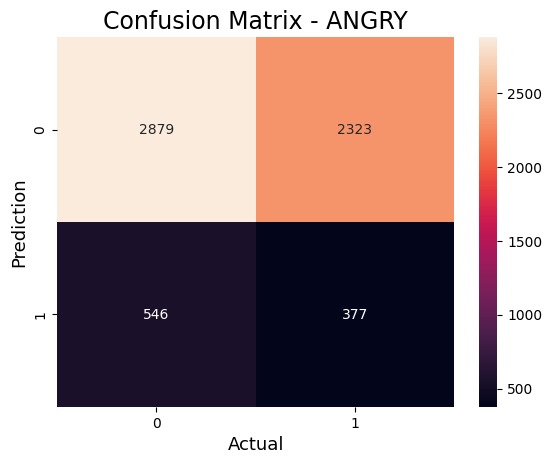

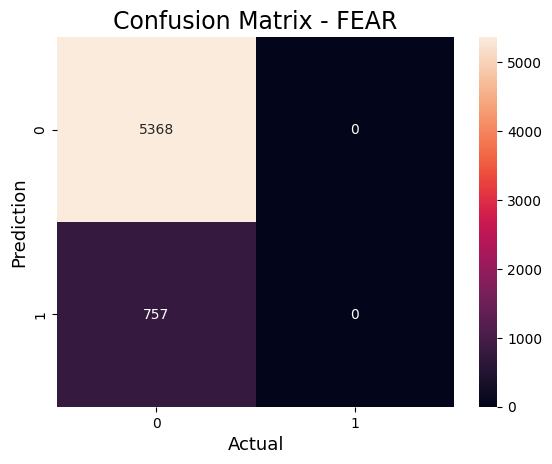

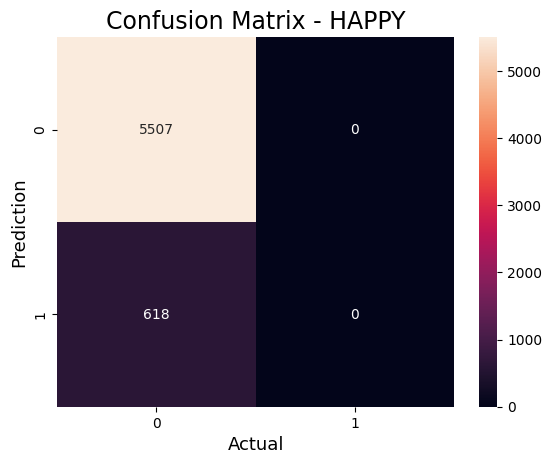

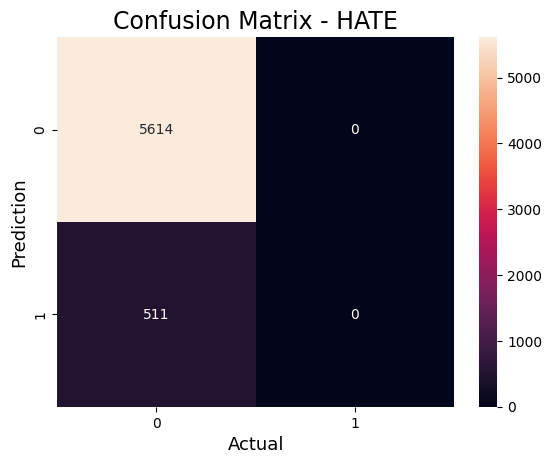

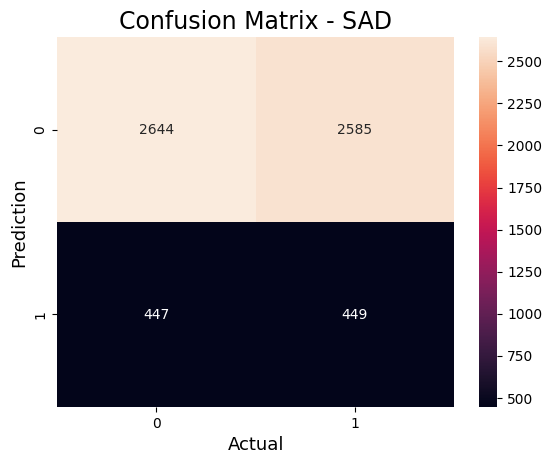

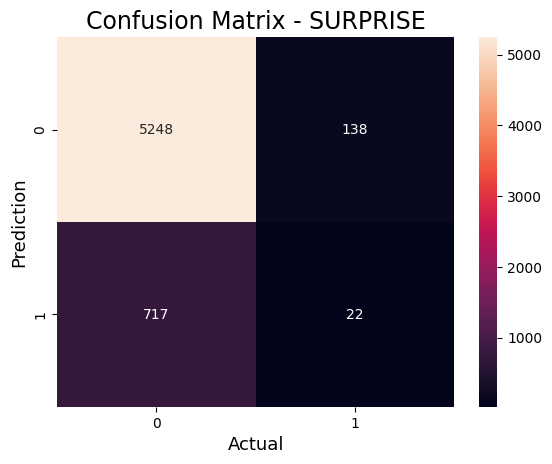

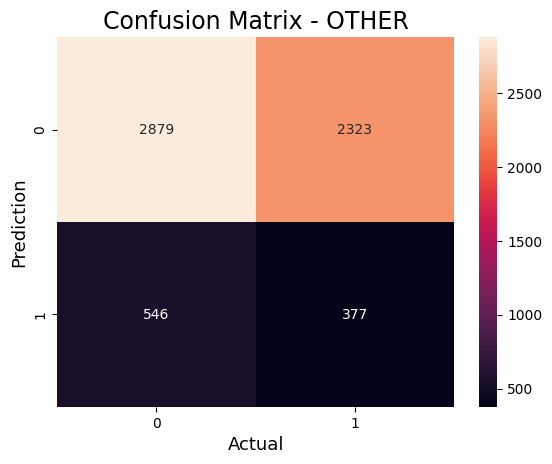

In [ ]:
# Plot all Confusion Matrices
for lbl, cm in confusion_matrices.items():
    sns.heatmap(cm, annot=True, fmt='g')
    plt.ylabel('Prediction', fontsize=13)
    plt.xlabel('Actual', fontsize=13)
    plt.title(f'Confusion Matrix - {lbl}', fontsize=17)
    plt.savefig(f'confusion_matrix_{lbl}.png')  # Save the confusion matrix plot as an image
    plt.show()